## **Install Dependencies**

In [ ]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn

In [2]:
!pip uninstall matplotlib --yes
!pip install matplotlib==3.1.3 

Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp39-cp39-macosx_11_0_arm64.whl


## **Importing Libraries**

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import zipfile
import wfdb as wf
import os
from scipy import signal
from biosppy.signals import ecg
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn import metrics

## **Importing Image Data**

In [4]:
base_dir = os.path.join('./data_ecg/Spectrogram/')
Abnormal_dir = os.path.join(base_dir,'Abnormal')
Normal_dir = os.path.join(base_dir,'Normal')

Abnormal_files = glob(Abnormal_dir+'/*.png')
Normal_files = glob(Normal_dir+'/*.png')
len(Abnormal_files), len(Normal_files)

(76871, 76871)

In [5]:
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': Abnormal_files + Normal_files,
    'label': ['abnormal'] * len(Abnormal_files) + ['normal'] * len(Normal_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./data_ecg/Spectrogram/Normal/79717.png,normal
1,./data_ecg/Spectrogram/Abnormal/118632.png,abnormal
2,./data_ecg/Spectrogram/Normal/6741.png,normal
3,./data_ecg/Spectrogram/Abnormal/138937.png,abnormal
4,./data_ecg/Spectrogram/Abnormal/60980.png,abnormal


## **Image data split**

In [6]:
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))



(96857,) (10762,) (46123,)
Train: Counter({'abnormal': 48586, 'normal': 48271}) 
Val: Counter({'normal': 5432, 'abnormal': 5330}) 
Test: Counter({'normal': 23168, 'abnormal': 22955})


## **Image reshaping**

In [7]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_11: working on img num: 5000
ThreadPoolExecutor-0_6: working on img num: 10000
ThreadPoolExecutor-0_0: working on img num: 15000
ThreadPoolExecutor-0_7: working on img num: 20000
ThreadPoolExecutor-0_2: working on img num: 25000
ThreadPoolExecutor-0_8: working on img num: 30000
ThreadPoolExecutor-0_3: working on img num: 35000
ThreadPoolExecutor-0_7: working on img num: 40000
ThreadPoolExecutor-0_11: working on img num: 45000
ThreadPoolExecutor-0_6: working on img num: 50000
ThreadPoolExecutor-0_3: working on img num: 55000
ThreadPoolExecutor-0_8: working on img num: 60000
ThreadPoolExecutor-0_10: working on img num: 65000
ThreadPoolExecutor-0_3: working on img num: 70000
ThreadPoolExecutor-0_0: working on img num: 75000
ThreadPoolExecutor-0_0: working on img num: 80000
ThreadPoolExecutor-0_2: working on img num: 85000
ThreadPoolExecutor-0_9: working on img num: 90000
ThreadPoolExecutor-0

In [8]:
IMG_DIMS = (124, 124)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_5: working on img num: 5000
ThreadPoolExecutor-1_6: working on img num: 10000
ThreadPoolExecutor-1_0: working on img num: 15000
ThreadPoolExecutor-1_9: working on img num: 20000
ThreadPoolExecutor-1_1: working on img num: 25000
ThreadPoolExecutor-1_6: working on img num: 30000
ThreadPoolExecutor-1_2: working on img num: 35000
ThreadPoolExecutor-1_1: working on img num: 40000
ThreadPoolExecutor-1_8: working on img num: 45000
ThreadPoolExecutor-1_7: working on img num: 50000
ThreadPoolExecutor-1_10: working on img num: 55000
ThreadPoolExecutor-1_8: working on img num: 60000
ThreadPoolExecutor-1_1: working on img num: 65000
ThreadPoolExecutor-1_9: working on img num: 70000
ThreadPoolExecutor-1_8: working on img num: 75000
ThreadPoolExecutor-1_8: working on img num: 80000
ThreadPoolExecutor-1_2: working on img num: 85000
ThreadPoolExecutor-1_2: working on img num: 90000
ThreadPoolExecutor-1_11: working

((96857, 124, 124, 3), (10762, 124, 124, 3), (46123, 124, 124, 3))

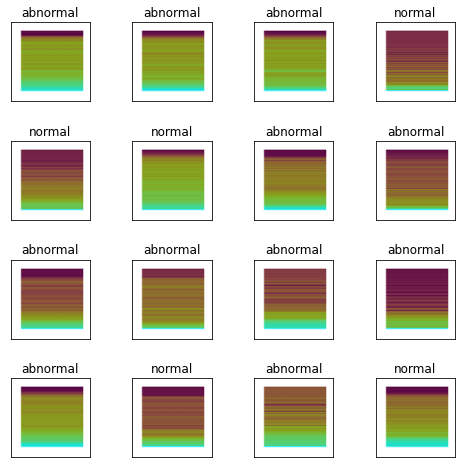

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [10]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 50
INPUT_SHAPE = (124, 124, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['normal' 'abnormal' 'abnormal' 'abnormal' 'normal' 'abnormal'] [1 0 0 0 1 0]


## **CNN Model Architecture**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam

In [12]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
batch1 = tf.keras.layers.BatchNormalization()(conv1)

pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(batch1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
batch2 = tf.keras.layers.BatchNormalization()(conv2)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(batch2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(2, 2), 
                               activation='relu', padding='same')(pool2)
batch3 = tf.keras.layers.BatchNormalization()(conv3)

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(batch3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(128, activation='relu')(flat)

hidden2 = tf.keras.layers.Dense(256, activation='relu')(hidden1)

out = tf.keras.layers.Dense(1, activation='sigmoid')(hidden2)

In [13]:
model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0     

## **Model Train**

In [14]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    #callbacks=callbacks,
                    verbose=1)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1514/1514 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8386WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2a7b96dc0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

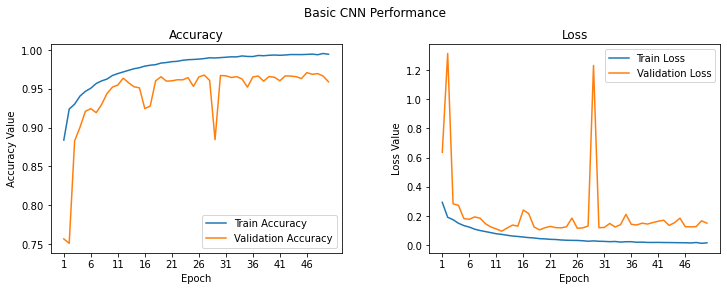

In [15]:
 f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [16]:
model.save('CNN_version_2.h5')

In [11]:
basic_cnn = tf.keras.models.load_model('./CNN_version_2.h5')

## **Model Evaluation**

In [12]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((46123, 124, 124, 3), (46123,))

In [13]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [14]:
basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])

In [15]:
print('Accuracy:', (metrics.accuracy_score(test_labels, basic_cnn_pred_labels),4))

Accuracy: (0.9624048739240726, 4)


In [16]:
print('Precision:',(metrics.precision_score(test_labels, basic_cnn_pred_labels,average='weighted'),
    4))

Precision: (0.9625067588702848, 4)


In [17]:
print('Recall:',(metrics.recall_score(test_labels, basic_cnn_pred_labels,average='weighted'),4))

Recall: (0.9624048739240726, 4)


In [18]:
 print('F1 Score:',(metrics.f1_score(test_labels, basic_cnn_pred_labels,average='weighted'),4))

F1 Score: (0.9624041272581109, 4)


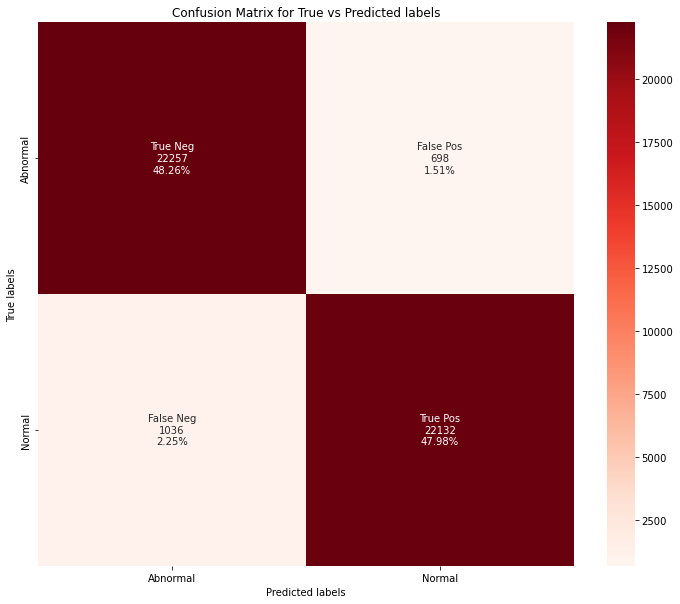

In [19]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

cm_data = confusion_matrix(test_labels, basic_cnn_pred_labels, labels=["abnormal", "normal"])
# ax= plt.subplot()
fig, ax = plt.subplots(figsize=(12, 10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_data.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_data.flatten()/np.sum(cm_data)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_data, annot=labels, fmt='', ax=ax, cmap='Reds');

# # labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for True vs Predicted labels'); 
ax.xaxis.set_ticklabels(['Abnormal', 'Normal']); ax.yaxis.set_ticklabels(['Abnormal', 'Normal']);

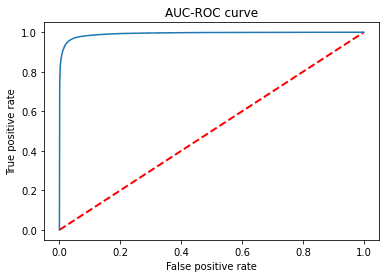

In [21]:
y_scores=basic_cnn_preds[:,0]
y_true=test_labels[:]
fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label='normal')
plt.title("AUC-ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)
# plt.legend(loc=4)
plt.show()